# Book Analytics Notebook

This notebook loads the `books.json` dataset and creates the required charts using pandas and matplotlib.

Rows: 500
Columns: ['book_id', 'title', 'author', 'genre', 'publication_year', 'page_count', 'average_rating', 'ratings_count', 'price_usd', 'publisher', 'language', 'format', 'in_print', 'sales_millions', 'last_checkout', 'available']


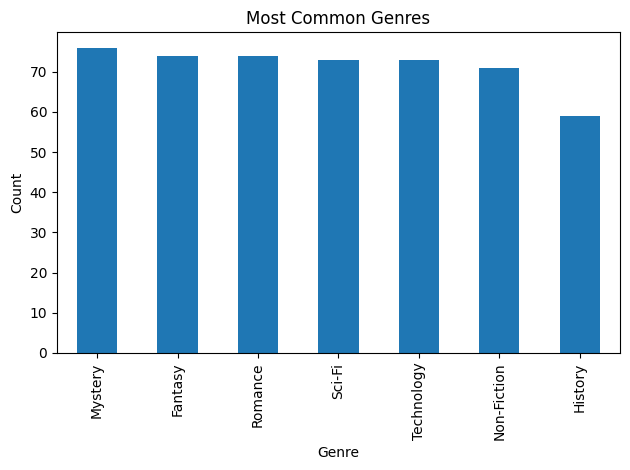

Saved: genre_counts.png


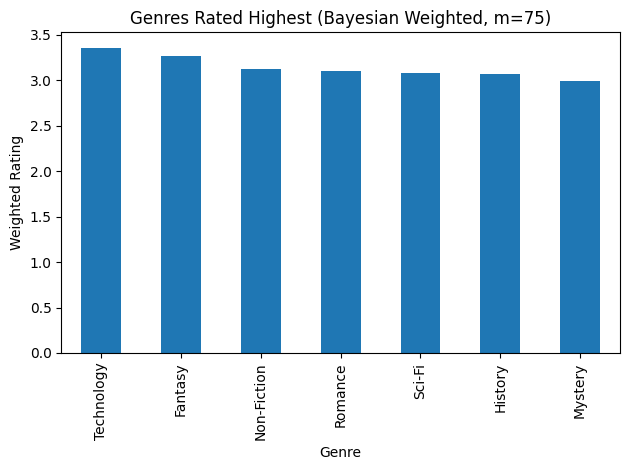

Saved: genre_weighted_ratings.png


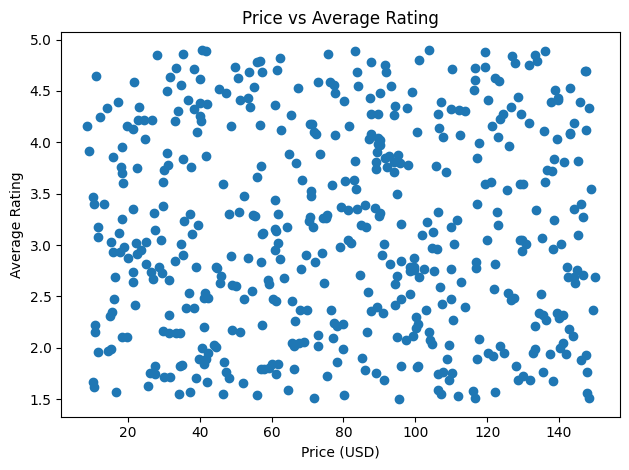

Saved: price_vs_rating_scatter.png


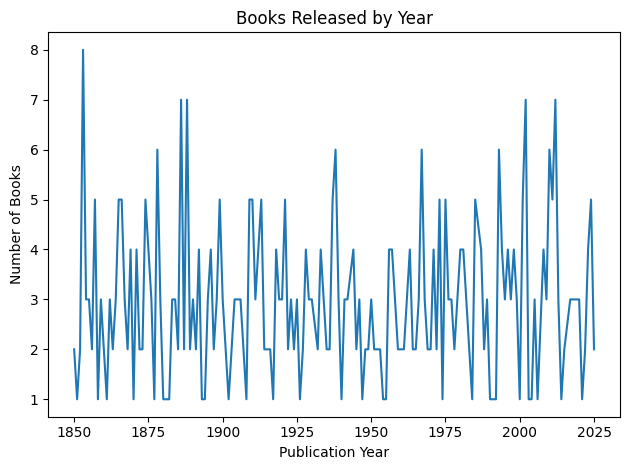

Saved: books_by_year_line.png


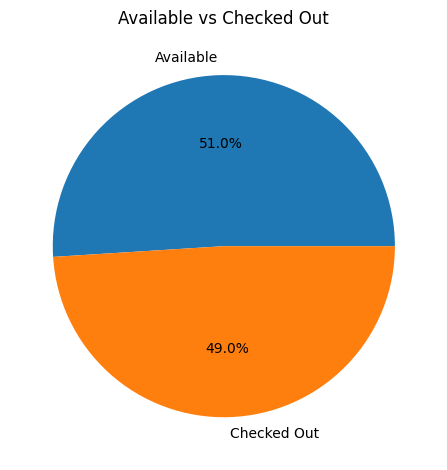

Saved: available_vs_checkedout_pie.png


In [ ]:
# --- Analytics Notebook (Project 1 ) ---
# Libraries (required)
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 1) Load books.json 
DATA_PATH = Path("../books.json")

with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw = json.load(f)


if isinstance(raw, dict):
    raw = raw.get("books", [])

df = pd.DataFrame(raw)

print("Rows:", len(df))
print("Columns:", df.columns.tolist())


# 2) Clean / normalize columns to match spec
# Required fields used in charts:
# genre, average_rating, ratings_count, price_usd, publication_year, available
def to_num(series):
    return pd.to_numeric(series, errors="coerce")

# Ensure columns exist even if missing
for col in ["genre", "average_rating", "ratings_count", "price_usd", "publication_year", "available"]:
    if col not in df.columns:
        df[col] = np.nan

# Convert numeric columns
df["average_rating"] = to_num(df["average_rating"])
df["ratings_count"] = to_num(df["ratings_count"])
df["price_usd"] = to_num(df["price_usd"])
df["publication_year"] = to_num(df["publication_year"])

# Normalize genre 
def genre_label(x):
    if pd.isna(x):
        return "Unknown"
    try:
        if isinstance(x, (int, np.integer)):
            return str(int(x))
        if isinstance(x, (float, np.floating)) and float(x).is_integer():
            return str(int(x))
    except Exception:
        pass
    return str(x).strip() if str(x).strip() else "Unknown"

df["genre_label"] = df["genre"].apply(genre_label)

# Normalize available to boolean 
# Accepts True/False, "true"/"false", 1/0.
def to_bool(x):
    if isinstance(x, bool):
        return x
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ("true", "1", "yes", "y", "available"):
        return True
    if s in ("false", "0", "no", "n", "unavailable"):
        return False
    return np.nan

df["available"] = df["available"].apply(to_bool)

# Drop rows with no genre (we keep Unknown instead of dropping)
df["genre_label"] = df["genre_label"].fillna("Unknown")

# Helpful quick view
df.head(3)


# 3) BAR CHART: Most common genres
genre_counts = df["genre_label"].value_counts().sort_values(ascending=False)

plt.figure()
genre_counts.plot(kind="bar")
plt.title("Most Common Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("genre_counts.png", dpi=200)
plt.show()

print("Saved: genre_counts.png")


# 4) BAR CHART: Genres rated highest using Bayesian weighted rating
# Spec mentions Bayesian Average. Standard approach:
# weighted_rating = (v/(v+m))*R + (m/(v+m))*C
# where:
# v = ratings_count (per book)
# R = average_rating (per book)
# C = mean rating across all books
# m = minimum ratings threshold (50-100 recommended)

m = 75  # choose a value in 50-100 range
C = df["average_rating"].mean(skipna=True)

# Avoid division by zero; v can be NaN
v = df["ratings_count"].fillna(0)
R = df["average_rating"].fillna(C)

df["weighted_rating"] = (v / (v + m)) * R + (m / (v + m)) * C

# Aggregate by genre: average weighted rating per genre 
genre_weighted = (
    df.groupby("genre_label")["weighted_rating"]
      .mean()
      .sort_values(ascending=False)
)

plt.figure()
genre_weighted.plot(kind="bar")
plt.title(f"Genres Rated Highest (Bayesian Weighted, m={m})")
plt.xlabel("Genre")
plt.ylabel("Weighted Rating")
plt.tight_layout()
plt.savefig("genre_weighted_ratings.png", dpi=200)
plt.show()

print("Saved: genre_weighted_ratings.png")


# 5) SCATTER: Do higher priced books have better ratings?
scatter_df = df.dropna(subset=["price_usd", "average_rating"])

plt.figure()
plt.scatter(scatter_df["price_usd"], scatter_df["average_rating"])
plt.title("Price vs Average Rating")
plt.xlabel("Price (USD)")
plt.ylabel("Average Rating")
plt.tight_layout()
plt.savefig("price_vs_rating_scatter.png", dpi=200)
plt.show()

print("Saved: price_vs_rating_scatter.png")


# 6) LINE CHART: Books released by year
year_counts = (
    df.dropna(subset=["publication_year"])
      .assign(publication_year=lambda x: x["publication_year"].astype(int))
      .groupby("publication_year")
      .size()
      .sort_index()
)

plt.figure()
plt.plot(year_counts.index, year_counts.values)
plt.title("Books Released by Year")
plt.xlabel("Publication Year")
plt.ylabel("Number of Books")
plt.tight_layout()
plt.savefig("books_by_year_line.png", dpi=200)
plt.show()

print("Saved: books_by_year_line.png")


# 7) PIE CHART: Checked in vs available books
# Interpret "checked in vs available" as:
# available=True vs available=False (checked out)
avail_counts = df["available"].value_counts(dropna=False)

available = int(avail_counts.get(True, 0))
checked_out = int(avail_counts.get(False, 0))
unknown = int(avail_counts.get(np.nan, 0)) 

labels = ["Available", "Checked Out"]
sizes = [available, checked_out]



plt.figure()
plt.pie(sizes, labels=labels, autopct="%1.1f%%")
plt.title("Available vs Checked Out")
plt.tight_layout()
plt.savefig("available_vs_checkedout_pie.png", dpi=200)
plt.show()

print("Saved: available_vs_checkedout_pie.png")
